Fitting 3 folds for each of 100 candidates, totalling 300 fits
Mean Absolute Error (MAE): 211.26
Root Mean Squared Error (RMSE): 283.14
R2 Score: 0.36


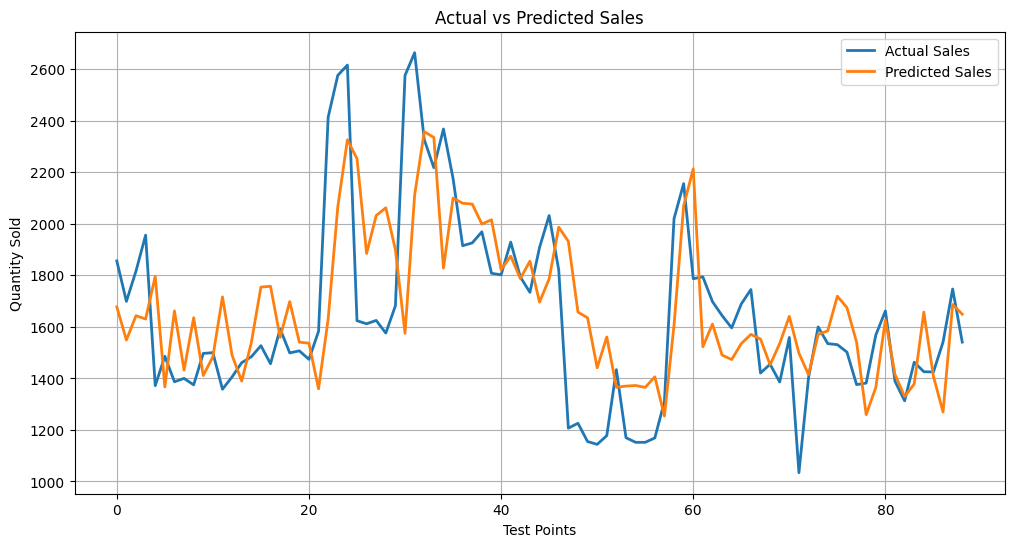

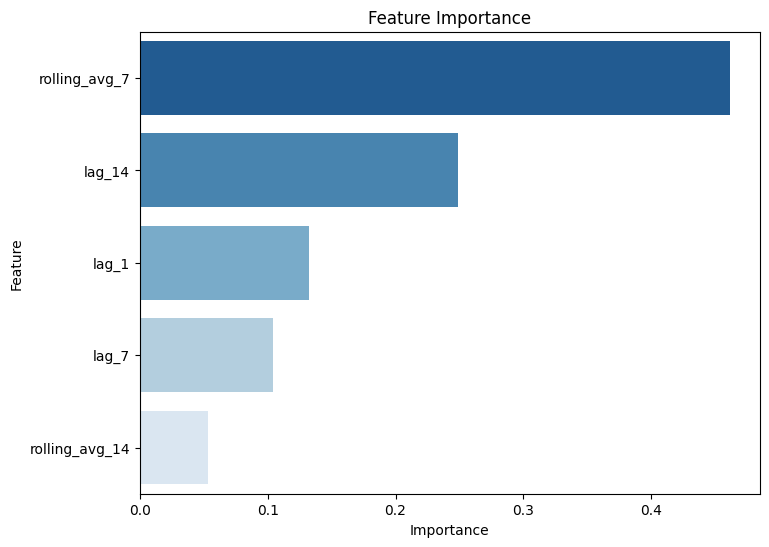

{'colsample_bytree': np.float64(0.6939633979404395), 'learning_rate': np.float64(0.22546586919516892), 'max_depth': 3, 'n_estimators': 268, 'subsample': np.float64(0.6234363473311589)}


In [3]:
# Demand Forecasting Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from scipy.stats import uniform, randint

# Data Loading
file_path = '/content/Beco data.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Data Preparing
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Simple Features
df['day_of_week'] = df['date'].dt.dayofweek
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
df['month'] = df['date'].dt.month


daily_sales = df.groupby('date').agg({
    'qty_sold': 'sum'
}).reset_index()

# Lag Features
daily_sales['lag_1'] = daily_sales['qty_sold'].shift(1)
daily_sales['lag_7'] = daily_sales['qty_sold'].shift(7)
daily_sales['lag_14'] = daily_sales['qty_sold'].shift(14)

# Moving Averages
daily_sales['rolling_avg_7'] = daily_sales['qty_sold'].rolling(window=7).mean()
daily_sales['rolling_avg_14'] = daily_sales['qty_sold'].rolling(window=14).mean()

# Removing rows with missing values (due to lagging)
model_data = daily_sales.dropna()

# Inputs and Output
features = ['lag_1', 'lag_7', 'lag_14', 'rolling_avg_7', 'rolling_avg_14']
target = 'qty_sold'

X = model_data[features]
y = model_data[target]

# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Model tuning
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=14)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=14,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

# Model Performance
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

# Plotting Predictions vs Actuals
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual Sales', linewidth=2)
plt.plot(y_pred, label='Predicted Sales', linewidth=2)
plt.title('Actual vs Predicted Sales')
plt.xlabel('Test Points')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid()
plt.show()

# Imp Features
importances = best_model.feature_importances_
feature_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_imp_df, palette='Blues_r', legend=False)
plt.title('Feature Importance')
plt.show()

# Best Parameter
print(random_search.best_params_)
